# ====== 2nd order SINDY autoencoder =====

In [64]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os

In [65]:
#Set seed for reproducibility
def seeding(seed):
    #random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [66]:
seeding(123)

In [67]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [68]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_cached()/1024**2)

In [69]:
# free up memory, and cuda memory
import gc
gc.collect()
torch.cuda.empty_cache()
memory_stats()

10435.5263671875
10620.0


/tmp/ipykernel_6078/3746055972.py:3: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(torch.cuda.memory_cached()/1024**2)


## Load data

In [70]:
index = 1

In [71]:
X = np.load(os.getcwd()+f'/simulations/X_{index}.npy')
Xdot = np.load(os.getcwd()+f'/simulations/Xdot_{index}.npy')
Xddot = np.load(os.getcwd()+f'/simulations/Xddot_{index}.npy')
X.shape, Xdot.shape, Xddot.shape

((150, 500, 97, 97), (150, 500, 97, 97), (150, 500, 97, 97))

In [72]:
# Load true angle values.
# These labels are not used in training, just to compare with atent space
Y = np.load(os.getcwd()+f'/simulations/Y_{index}.npy')
Y.shape

(150, 500)

In [73]:
img_sz = X.shape[2]
img_sz

97

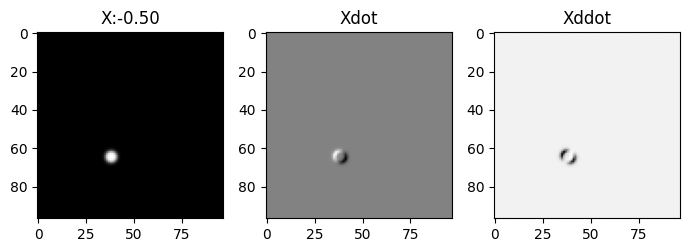

In [74]:
simul = 25
tstep = 123
fig = plt.figure(figsize=(7,7))
plt.subplot(1,3,1)
plt.imshow(X[simul,tstep],cmap='grey')
plt.title(f'X:{Y[simul,tstep]:0.2f}')
plt.subplot(1,3,2)
plt.imshow(Xdot[simul,tstep],cmap='grey')
plt.title('Xdot')
plt.subplot(1,3,3)
plt.imshow(Xddot[simul,tstep],cmap='grey')
plt.title('Xddot')
plt.tight_layout()

In [75]:
# Create reshaped tensors
X_data = torch.tensor(X.reshape((X.shape[0]*X.shape[1],X.shape[2]*X.shape[3]))).to(device)
Xdot_data = torch.tensor(Xdot.reshape((Xdot.shape[0]*Xdot.shape[1],Xdot.shape[2]*Xdot.shape[3]))).to(device)
Xddot_data = torch.tensor(Xddot.reshape((Xddot.shape[0]*Xddot.shape[1],Xddot.shape[2]*Xddot.shape[3]))).to(device)
X_data.shape, Xdot_data.shape, Xddot_data.shape

(torch.Size([75000, 9409]),
 torch.Size([75000, 9409]),
 torch.Size([75000, 9409]))

In [76]:
Y_data = torch.tensor(Y.reshape((Y.shape[0]*Y.shape[1]))).to(device)
Y_data.shape

torch.Size([75000])

In [77]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create datasets
train_dataset, test_dataset = random_split(TensorDataset(X_data, Xdot_data, Xddot_data, Y_data), [0.8, 0.2],
                                           generator=torch.Generator().manual_seed(123))

In [78]:
# Create dataloaders
batch_size_train = 64
batch_size_test = 500

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

In [79]:
xn_val = 0
xddn_val = 0
for (b_x, _, b_xddot, _) in train_dataset:
    xn_val += torch.linalg.vector_norm(b_x)
    xddn_val += torch.linalg.vector_norm(b_xddot)
l1_val = xn_val/xddn_val
l1_val

tensor(0.0045, device='cuda:0')

## Autoencoder network
![](autoencoder.png)

The autoencoder network is composed by two functions, an encoder function $\varphi$, and a decoder function $\psi$, so that
$$\mathbf{z}(t)=\varphi(\mathbf{x}(t)),$$
$$\hat{\mathbf{x}}(t)=\psi(\mathbf{z}(t)).$$

There are $n$ samples of the input of dimension $m$, so that it can be stored in a matrix
$$\mathbf{X}=\left[\begin{array}{cccc}x_1(t_1)&x_2(t_1)&\cdots&x_m(t_1)\\x_1(t_2)&x_2(t_2)&\cdots&x_m(t_2)\\\vdots&\vdots&\ddots&\vdots\\x_1(t_n)&x_2(t_n)&\cdots&x_m(t_n)\\\end{array}\right]=\left[\begin{array}{c}\mathbf{x}(t_1)\\\mathbf{x}(t_2)\\\vdots\\\mathbf{x}(t_n)\end{array}\right].$$

It is important to note that here $t_i$ identifies the sample, not the time at which it was taken, and thus it does not folow a chronological order. The time enters into the problem by the relation of $\mathbf{X}$ and its time derivatives.  

In the same way, the latent space of dimension $k$ can be cast into a matrix form
$$\mathbf{Z}=\left[\begin{array}{cccc}z_1(t_1)&z_2(t_1)&\cdots&z_k(t_1)\\z_1(t_2)&z_2(t_2)&\cdots&z_k(t_2)\\\vdots&\vdots&\ddots&\vdots\\z_1(t_n)&z_2(t_n)&\cdots&z_k(t_n)\\\end{array}\right]=\left[\begin{array}{c}\mathbf{z}(t_1)\\\mathbf{z}(t_2)\\\vdots\\\mathbf{z}(t_n)\end{array}\right].$$

## SINDy

While the autoencoder is concerned with the dimensionality reduction from the input to the latent space, the model (diferential equation) in that latent space is fitted by means of the SINDy (sparse identification of nonlinear dynamics) algorithm. 2nd order SINDy assumes that the dynamics for the latent space variables is described by
$$\ddot{\mathbf{z}}(t)=\epsilon_0+\sum_{i=1}^N\epsilon_if_i(\mathbf{z},\dot{\mathbf{z}};t),$$

where the $f_i$ are a set of $N$ base functions of $\mathbf{z}$ and $\dot{\mathbf{z}}$ called the SINDy library, and $\epsilon_i=[\varepsilon_{i,1},\varepsilon_{i,2},\cdots,\varepsilon_{i,k}]$, $0\leq i\leq N$, are the weights associated with each function $f_i$ for each of the variables $z_j$. The idea behind SINDy is that most of the $\varepsilon_{i,j}$ weights will tend to zero during the training of the model, so as to produce a sparse model. The resulting system of differential equations can be cast in a matrix form as
$$\ddot{\mathbf{Z}}=\left[\begin{array}{cccc}1&f_1(t_1)&\cdots&f_N(t_1)\\1&f_1(t_2)&\cdots&f_N(t_2)\\\vdots&\vdots&\ddots&\vdots\\1&f_1(t_n)&\cdots&f_N(t_n)\end{array}\right]\left[\begin{array}{cccc}\varepsilon_{01}&\varepsilon_{02}&\cdots&\varepsilon_{0k}\\\varepsilon_{11}&\varepsilon_{12}&\cdots&\varepsilon_{1k}\\\vdots&\vdots&\ddots&\vdots\\\varepsilon_{N1}&\varepsilon_{N2}&\cdots&\varepsilon_{Nk}\end{array}\right]=\Theta(\mathbf{Z},\dot{\mathbf{Z}})\ \Xi.$$

#### Example
For example, say we decide for the latent space to be of dimension $k=2$, and we create a SINDy library composed by the functions $f_1(\mathbf{z},\dot{\mathbf{z}})=z_1$, $f_2(\mathbf{z},\dot{\mathbf{z}})=z_2$, $f_3(\mathbf{z},\dot{\mathbf{z}})=\dot{z}_1$, $f_4(\mathbf{z},\dot{\mathbf{z}})=\dot{z}_2$, $f_5(\mathbf{z},\dot{\mathbf{z}})=z_1^2$, $f_6(\mathbf{z},\dot{\mathbf{z}})=z_2^2$, and $f_7(\mathbf{z},\dot{\mathbf{z}})=z_1z_2$. Imagine that by the end of the training process the coefficients take the values

$$\left[\begin{array}{cc}\varepsilon_{01}&\varepsilon_{02}\\\varepsilon_{11}&\varepsilon_{12}\\\varepsilon_{21}&\varepsilon_{22}\\\varepsilon_{31}&\varepsilon_{32}\\\varepsilon_{41}&\varepsilon_{42}\\\varepsilon_{51}&\varepsilon_{52}\\\varepsilon_{61}&\varepsilon_{62}\\\varepsilon_{71}&\varepsilon_{72}\end{array}\right]=\left[\begin{array}{cc}0&1\\1&0\\0&0\\0&1\\0&0\\1&0\\0&1\\0&1\end{array}\right],$$
then the resulting dynamic equations would be
$$\ddot{z}_1=z_1+z_1^2,$$
$$\ddot{z}_2=1+\dot{z}_1+z_2^2+z_1z_2.$$

## Training

Training the model is a regression process thet requires de defintion of a loss function which has to be minimized. The loss function for the SINDy autoencoder is composed of four terms. The first term, reconstruction loss, is the typical mean square function for an autoencoder:
$$J_0=\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2.$$
The second term enforces the convergence of the second derivative for the input
$$J_1=\|\ddot{\mathbf{x}}-\ddot{\hat{\mathbf{x}}}\|_2^2.$$
The third term enforces the dynamical equation for the latent space
$$J_2=\|\ddot{\mathbf{z}}-\Theta(\mathbf{z},\dot{\mathbf{z}})\Xi\|_2^2.$$
And the last term is a regularization that promtes sparsity for the SINDy coefficients
$$J_3=\|\Xi\|_1.$$
The total loss function is then
$$J=J_0+\lambda_1J_1+\lambda_2J_2+\lambda_3J_3,$$
where the $\lambda_i$ are hyperparameters of the trainig process.

Let $\mathbf{W}_i$ be the weight matrices of the layers in the network, and $\mathbf{b}_i$ be the bias. We compute the function $$\varphi(\mathbf{x})=\mathbf{W}_{L-1}\mathbf{a}_{L-1}+\mathbf{b}_{L-1},$$
where $L$ is the number of layers of the encoder/decoder,
$$\mathbf{a}_i=h(\zeta_{i-1}),\ \zeta_{i}=\mathbf{W}_{i}\mathbf{a}_i+\mathbf{b}_i,$$
and $h(\zeta)$ is the activation function. To compute $\varphi$ we iterate over the layers of the network and obtain all $\mathbf{a}_i$'s we iterate over the layers
$$\mathbf{a}_1=h(\mathbf{W}_{0}\mathbf{x}+\mathbf{b}_0)$$
$$\vdots$$
$$\mathbf{a}_i=h(\mathbf{W}_{i-1}\mathbf{a}_{i-1}+\mathbf{b}_{i-1})$$
$$\vdots$$
$$\varphi(\mathbf{x})=\mathbf{W}_{L-1}\mathbf{a}_{L-1}+\mathbf{b}_{L-1}.$$

In order to minimize the loss function the gradient descent algorithm is used. This requires for us to obtain the gradient of the loss function with respect to all of the coefficients, including the network weights and SINDy coefficients.\
t\ddot{\mathbf{x}}$$

In addition, to obtain the time derivatives $\ddot{\hat{\mathbf{x}}}$ and $\ddot{\mathbf{z}}$, which are required to compute the loss function, we will need to compute gradients with respect to these variables, as the time derivative of $\varphi$ is
$$\frac{d\varphi}{dt}(\mathbf{x})=\nabla_{\mathbf{x}}\varphi(\mathbf{x})\cdot\dot{\mathbf{x}}=\mathbf{W}_{L-1}\frac{d\mathbf{a}_{L-1}}{dt}$$
which, in the case where $h$ is the sigmoid function, is calculated as
$$\dot{\mathbf{a}}_1=\mathbf{a}_1(1-\mathbf{a}_1)\mathbf{W}_0\dot{\mathbf{x}}$$
$$\vdots$$
$$\dot{\mathbf{a}}_i=\mathbf{a}_i(1-\mathbf{a}_i)\mathbf{W}_{i-1}\dot{\mathbf{a}}_{i-1}$$
$$\vdots$$
$$\frac{d\varphi}{dt}=\mathbf{W}_{L-1}\dot{\mathbf{a}}_{L-1}.$$

The 2nd time derivative is
$$\frac{d^2\varphi}{dt^2}(\mathbf{x})=\nabla_{\mathbf{x}}\left(\nabla_{\mathbf{x}}\varphi(\mathbf{x})\cdot\dot{\mathbf{x}}\right)\cdot\dot{\mathbf{x}}+\nabla_{\mathbf{x}}\varphi(\mathbf{x})\cdot\ddot{\mathbf{x}}=\mathbf{W}_{L-1}\frac{d\dot{\mathbf{a}}_{L-1}}{dt},$$
which in the case $h$ is the logistic function, is calculated as
$$\ddot{\mathbf{a}}_1=(2\mathbf{a}_1^3-3\mathbf{a}_1^2+\mathbf{a}_1)\mathbf{W}_0\dot{\mathbf{x}}\mathbf{W}_0\dot{\mathbf{x}}+\mathbf{a}_1(1-\mathbf{a}_1)\mathbf{W}_0\ddot{\mathbf{x}}$$
$$\vdots$$
$$\ddot{\mathbf{a}}_i=(2\mathbf{a}_i^3-3\mathbf{a}_i^2+\mathbf{a}_i)\mathbf{W}_{i-1}\dot{\mathbf{a}}_{i-1}\mathbf{W}_{i-1}\dot{\mathbf{a}}_{i-1}+\mathbf{a}_i(1-\mathbf{a}_i)\mathbf{W}_{i-1}\ddot{\mathbf{a}}_{i-1}$$
$$\vdots$$
$$\frac{d^2\varphi}{dt^2}=\mathbf{W}_{L-1}\ddot{\mathbf{a}}_{L-1}.$$

The case of the decoder function $\psi(\mathbf{z})$ is similar, save for the last layer, which applies the sigmoid function. Therefore
$$\psi(\mathbf{z})=h(\mathbf{W}_{L-1}\mathbf{a}_{L-1}+\mathbf{b}_{L-1}),$$
$$\frac{d\psi}{dt}=\dot{\mathbf{a}}_{L-1}(1-\dot{\mathbf{a}}_{L-1})\mathbf{W}_{L-2}\dot{\mathbf{a}}_{L-2},$$
$$\frac{d^2\psi}{dt^2}=(2\mathbf{a}_{L-1}^3-3\mathbf{a}_{L-1}^2+\mathbf{a}_{L-1})\mathbf{W}_{L-2}\dot{\mathbf{a}}_{L-2}\mathbf{W}_{L-2}\dot{\mathbf{a}}_{L-2}+\mathbf{a}_{L-1}(1-\mathbf{a}_{L-1})\mathbf{W}_{L-2}\ddot{\mathbf{a}}_{L-2}.$$

#### Sequential thresholding
To promote sparsity in the weights that multiply the SINDy library, a mask is multiplied by this weight matrix. When one of the wheigts goes below certain threshold, the corresponding element in the mask goes from 1 to 0.

The dimension of the latent space will be chosen as 1, because the simple pendulum has a single degree of freedom. In a general case where this is not known a priory, the authors of the original paper suggest first training a standard autoencoder without the associated SINDy model to determine the minimum number of coordinates necessary to reproduce the input data.

The SINDy library will be composed of the following functions: $1$, $\mathbf{z}$, $\mathbf{z}^2$, $\mathbf{z}^3$, $\sin(\mathbf{z})$, $\cos(\mathbf{z})$, $\dot{\mathbf{z}}$, $\dot{\mathbf{z}}^2$, $\dot{\mathbf{z}}^3$, and $\mathbf{z}\dot{\mathbf{z}}$. 

Encoder:\
2601 => 1200 => 600 => 200 => 80 => 10 => 1  

Decoder:\
1 => 10 => 80 => 200 => 600 => 1200 => 2601

To choose hyperparameter $\lambda_1$, the authors suggest to use $\sum_i^m\|x_i\|_2^2/\sum_i^m\|\ddot{x}_i\|_2^2$. They suggest $\lambda_2$ to be two orders of magnitude less than $\lambda_1$. $\lambda_3$ should be shosen to acheive the desired level of sparsity in the SINDy coefficients.

In [80]:
#PARAMETERS
epochs = 50
log_interval = 100

learn_rate = 1.e-5
lambda1 = 0.#l1_val*0.9
lambda2 = 0.#lambda1/100
lambda3 = 0.#1.e-3
thresh = 0.01

In [81]:
# free up memory, and cuda memory
import gc
gc.collect()
torch.cuda.empty_cache()

In [82]:
from autoencoder.sindy_autoencoder import SindyAutoEncoder 

In [83]:
## Instantiate model (last layer size must be=1)
#model = SindyAutoEncoder(layer_sizes=[9409,4800,2400,1200,600,200,40,1]).to(device)

#Or load model parameters
model = torch.load('model.pt', weights_only=False)
model = model.to(device)

In [84]:
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learn_rate,
                             amsgrad=True,
                             weight_decay=1.e-8)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
sindy_weights = []
latent = []
theta = []

In [85]:
# Model trainer
def train(epoch, loss0, loss1, loss2, lambda1, lambda2, lambda3, thresh):
    model.train()
    for batch_idx, (batch_x, batch_xdot, batch_xddot, batch_y) in enumerate(train_loader):
        #Forward pass through the network
        x_hat = model(batch_x)
        
        #Reconstruction loss (J_0)
        J0 = loss0(x_hat, batch_x)

        #Zddot loss (J_2)
        z, zdot, zddot = model.tderiv_encoder(batch_x, batch_xdot, batch_xddot)
        sindy_lib = model.sindy_library(z, zdot) 
        zddot_hat = model.sindy(sindy_lib)
        J2 = loss2(zddot_hat, zddot)

        #Regularization loss (J_3)
        J3 = torch.sum(torch.abs(model.sindy.weight))

        #Xddot loss (J_1)
        x, xdot, xddot = model.tderiv_decoder(z, zdot, zddot)
        J1 = loss1(xddot, batch_xddot)

        #Total loss
        loss = J0 + lambda1*J1 + lambda2*J2 + lambda3*J3

        #Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Thresholding
        for i in range(model.sindy.weight.shape[1]):
            if model.sindy.weight[0,i] < thresh:
                model.mask[0,i] = 0
        with torch.no_grad():
            model.sindy.weight *= model.mask
        
        if batch_idx%log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx*len(batch_x), len(train_loader.dataset),
                100.*batch_idx/len(train_loader), loss.item()
            ))
            train_losses.append(loss.item())
            train_counter.append(batch_idx*batch_size_train + epoch*len(train_loader.dataset))
            #Keep track of sundy weights
            sindy_weights.append(model.sindy.weight.cpu().detach().numpy())
            #Value of the latent space z, and the true value theta
            latent.append(z.cpu().detach().numpy())
            theta.append(batch_y.cpu().detach().numpy())

# Model evaluation
def test(loss0, loss1, loss2, lambda1, lambda2, lambda3):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_xdot, batch_xddot, _ in test_loader:
            x_hat = model(batch_x)
            J0 = loss0(x_hat, batch_x)
            
            z, zdot, zddot = model.tderiv_encoder(batch_x, batch_xdot, batch_xddot)
            sindy_lib = model.sindy_library(z, zdot) 
            zddot_hat = model.sindy(sindy_lib)
            J2 = loss2(zddot_hat, zddot)
            
            J3 = torch.sum(torch.abs(model.sindy.weight))
            
            x, xdot, xddot = model.tderiv_decoder(z, zdot, zddot)
            J1 = loss1(xddot, batch_xddot)
            
            loss = J0 + lambda1*J1 + lambda2*J2 + lambda3*J3
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss,))  

In [86]:
with torch.no_grad():
    img_batch = next(iter(test_loader))

In [87]:
def show_img(sz):
    with torch.no_grad():
        img = img_batch[0]
        print(img.shape)
        reconst = model(img)
        img = img.cpu().detach()
        reconst = reconst.cpu().detach()
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,2,1)
        ax.imshow(img[0].reshape((sz,sz)), cmap='grey')
        plt.title('Input')
        #plt.grid(None)
        ax = fig.add_subplot(1,2,2)
        ax.imshow(reconst[0].reshape((sz,sz)), cmap='grey')
        plt.title('Reconstruction')
        #plt.grid(None)

In [88]:
loss0 = nn.MSELoss()
loss1 = nn.MSELoss()
loss2 = nn.MSELoss()


Test set: Avg. loss: 0.0021
Train Epoch: 0 [0/60000 (0%)]	Loss: 0.002054
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.002046
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.002053
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.002043
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.002020
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.002076
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.002056
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.002027
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.002055
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.002056

Test set: Avg. loss: 0.0021
torch.Size([500, 9409])
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.002054
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.002075
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.002065
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.002059
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.002054
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.002056
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.002083
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.002054
Train Epoch: 1 [51200/60000 (8

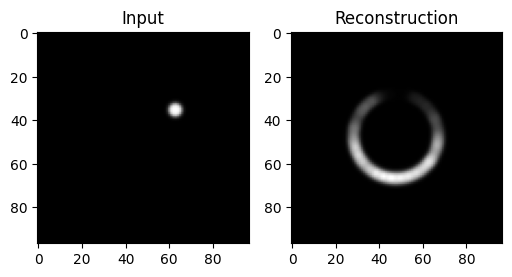

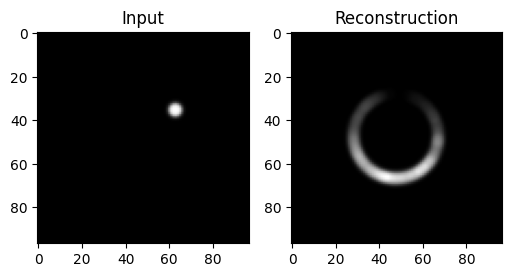

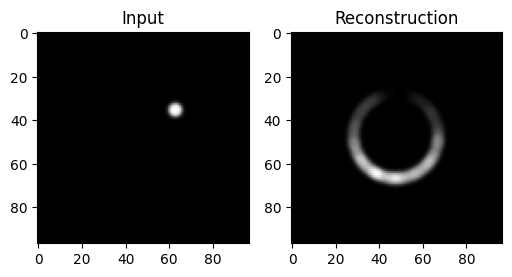

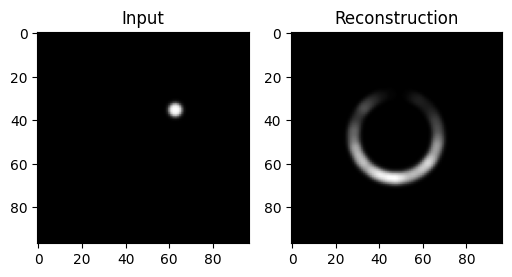

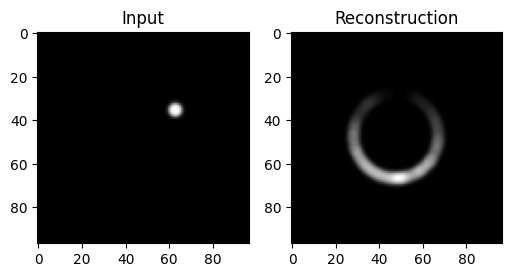

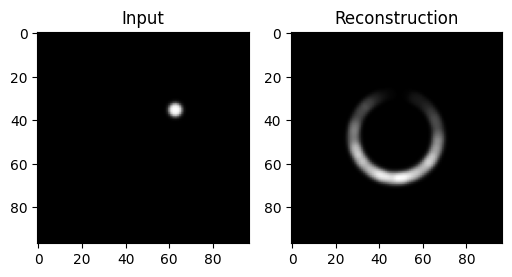

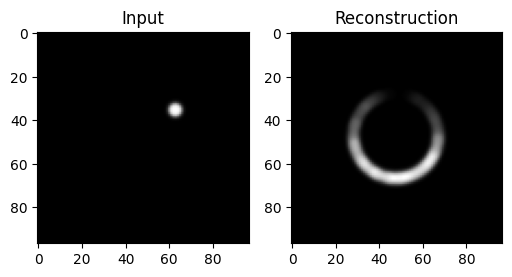

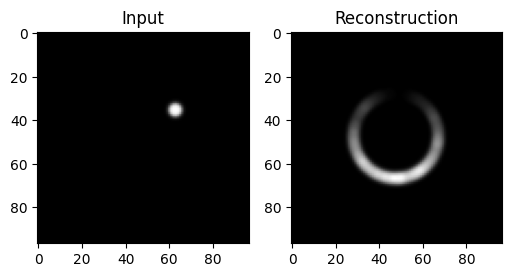

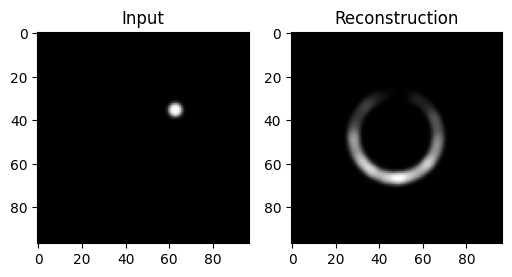

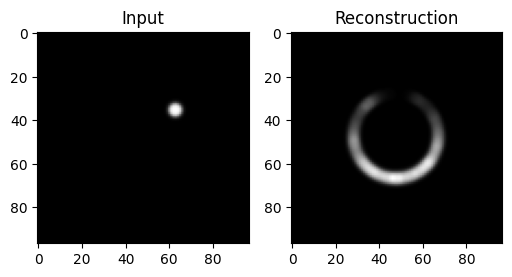

In [89]:
Nimshow = 5 #batch_size_test

test(loss0, loss1, loss2, lambda1, lambda2, lambda3)
for epoch in range(epochs):
    train(epoch, loss0, loss1, loss2, lambda1, lambda2, lambda3, thresh)
    test(loss0, loss1, loss2, lambda1, lambda2, lambda3)
    if epoch%Nimshow==0:
        show_img(img_sz)

In [90]:
#show_img(img_sz)

In [91]:
#Export model
torch.save(model, 'model.pt')

In [92]:
z = np.array(latent)
z = z.reshape(z.shape[0],z.shape[1])
T = np.array(theta)
z.shape, T.shape

((500, 64), (500, 64))

In [93]:
#Save training data
with open('train_data/train_losses.dat', 'w') as f:
    for i, val in zip(train_counter, train_losses):
        f.write(f'{i} {val}\n')

with open('train_data/test_losses.dat', 'w') as f:
    for i, val in zip(test_counter, test_losses):
        f.write(f'{i} {val}\n')

sindy_weights = np.array(sindy_weights)
sindy_w = sindy_weights.reshape(sindy_weights.shape[0],10)
with open('train_data/sindy_weights.dat', 'w') as f:
    for i in range(len(train_counter)):
        f.write(f'{train_counter[i]} ')
        for j in range(10):
            f.write(f'{sindy_w[i][j]} ')
        f.write('\n')
    
# z = np.array(latent)
# z = z.reshape(z.shape[0],z.shape[1])
# T = np.array(theta)
# with open('train_data/latent_vs_theta.dat', 'w') as f:
#     for i, valz, valT in zip(train_counter, z, T):
#         f.write(f'{i} {valz} {valT}\n')